In [25]:
#%pip install holidays
#%pip install pycountry
#%pip install pycountry_convert 
#%pip install nltk textblob wordcloud seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 10.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from scipy.stats import ttest_ind
import pycountry_convert as pc
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


## External Factors and Guest Segmentation

How does seasonality, public holidays and visitor demographics impact theme park attendance and reviews?

## Load Data

This data has been sourced from https://www.kaggle.com/datasets/ayushtankha/hackathon/data?select=waiting_times.csv, https://www.kaggle.com/datasets/arushchillar/disneyland-reviews/data and from https://queue-times.com/parks.
The aim of using the daily attendance data from PortAventura and Tivoli Gardens is to see if there are any seasonal trends in terms of popular months, days of weeks and holidays or local events while the disneyland reviews data and disneyland yearly attendance data will be used to explore if there is any relationship between ratings and dates.

#### The attendance data consists of 2 parks, PortAventura World and Tivoli Gardens from 2018 to 2022.

In [103]:
attendance_data = pd.read_csv("/Users/clarakan/DSA3101/Kaggle/attendance.csv")
attendance_data.head()


,USAGE_DATE,FACILITY_NAME,attendance
0,2018-06-01,PortAventura World,46804
1,2018-06-01,Tivoli Gardens,20420
2,2018-06-02,PortAventura World,57940
3,2018-06-02,Tivoli Gardens,29110
4,2018-06-03,PortAventura World,44365


#### The Disneyland reviews data consists of reviews from Hong Kong Disneyland, Paris Disneyland and California Disneyland.

In [104]:
DisneylandReviews_data = pd.read_csv("/Users/clarakan/DSA3101/Kaggle/DisneylandReviews.csv", encoding="latin-1")
DisneylandReviews_data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


#### The attendance data of DisneyLand Hong Kong, Paris and California.

In [109]:
attendance_disney = pd.read_csv("/Users/clarakan/DSA3101/Yearly Attendance Disney Paris Hong Kong Cali.csv")
attendance_disney.head()

,Park,Year,Attendance,Unnamed: 3
0,DisneyLand_HongKong,2023,6400000,NaN
1,DisneyLand_HongKong,2022,3400000,NaN
2,DisneyLand_HongKong,2021,2800000,NaN
3,DisneyLand_HongKong,2020,1700000,NaN
4,DisneyLand_HongKong,2019,5695000,NaN


## Data Pre-Processing
Handled null, duplicates, data type conversions, making additional columns to help in data analysis

#### Attendance Data

In [106]:
attendance_data.isnull().any()
attendance_data.drop_duplicates(inplace = True)
attendance_data["USAGE_DATE"] = pd.to_datetime(attendance_data["USAGE_DATE"])
attendance_data["Year"] = attendance_data["USAGE_DATE"].dt.year
attendance_data["Month"] = attendance_data["USAGE_DATE"].dt.month
attendance_data["Day_of_Week"] = attendance_data["USAGE_DATE"].dt.day_name()
for x in attendance_data.index:
  if attendance_data.loc[x, "attendance"] < 0:
    attendance_data.loc[x, "attendance"] = 0

attendance_data["mean_attendance"] = attendance_data.groupby(["Year", "FACILITY_NAME"])["attendance"].transform("mean")
attendance_data["std_attendance"] = attendance_data.groupby(["Year", "FACILITY_NAME"])["attendance"].transform("std")

# Standardize attendance
attendance_data["standardized_attendance"] = (attendance_data["attendance"] - attendance_data["mean_attendance"]) / attendance_data["std_attendance"]

attendance_data.head()

,USAGE_DATE,FACILITY_NAME,attendance,Year,Month,Day_of_Week,mean_attendance,std_attendance,standardized_attendance
0,2018-06-01,PortAventura World,46804,2018,6,Friday,45461.004673,13418.682302,0.100084
1,2018-06-01,Tivoli Gardens,20420,2018,6,Friday,22760.574766,7124.590921,-0.328521
2,2018-06-02,PortAventura World,57940,2018,6,Saturday,45461.004673,13418.682302,0.929972
3,2018-06-02,Tivoli Gardens,29110,2018,6,Saturday,22760.574766,7124.590921,0.891199
4,2018-06-03,PortAventura World,44365,2018,6,Sunday,45461.004673,13418.682302,-0.081678


#### Disneyland Reviews Data

In [107]:
print(DisneylandReviews_data["Year_Month"].unique())  # Check all unique values
print(DisneylandReviews_data["Year_Month"].isnull().sum())  # Count NaNs
DisneylandReviews_data = DisneylandReviews_data.dropna(subset=["Year_Month"])  # Remove rows with missing dates

DisneylandReviews_data["Year_Month"] = pd.to_datetime(
    DisneylandReviews_data["Year_Month"], format="%Y-%m", errors="coerce"
)
DisneylandReviews_data["Year"] = DisneylandReviews_data["Year_Month"].dt.year
DisneylandReviews_data["Month"] = DisneylandReviews_data["Year_Month"].dt.month

DisneylandReviews_data.head()

['2019-4' '2019-5' '2019-3' '2018-9' '2019-1' '2018-11' '2018-12' '2018-6'
 '2019-2' '2018-10' '2018-8' '2018-5' '2018-4' '2018-7' '2018-3' '2018-2'
 'missing' '2018-1' '2017-12' '2017-11' '2017-6' '2017-10' '2017-9'
 '2017-8' '2017-7' '2017-5' '2017-4' '2017-3' '2017-2' '2017-1' '2016-12'
 '2016-11' '2016-10' '2016-9' '2016-8' '2016-7' '2016-6' '2016-5' '2016-4'
 '2016-3' '2016-2' '2016-1' '2015-12' '2015-11' '2015-10' '2015-9'
 '2015-8' '2015-7' '2015-6' '2015-5' '2015-4' '2015-3' '2015-2' '2015-1'
 '2014-12' '2014-11' '2014-10' '2014-9' '2014-8' '2014-7' '2014-6'
 '2014-5' '2014-4' '2014-3' '2014-2' '2014-1' '2013-12' '2013-11'
 '2013-10' '2013-9' '2013-8' '2013-7' '2013-6' '2013-5' '2013-4' '2013-3'
 '2013-2' '2013-1' '2012-12' '2012-11' '2012-10' '2012-9' '2012-8'
 '2012-7' '2012-6' '2012-5' '2012-4' '2012-3' '2012-2' '2012-1' '2011-12'
 '2011-11' '2011-10' '2011-9' '2011-8' '2011-7' '2011-6' '2011-5' '2011-4'
 '2011-3' '2011-2' '2011-1' '2010-12' '2010-11' '2010-10' '2010-9'
 '20

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019.0,4.0
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019.0,5.0
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019.0,4.0
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019.0,4.0
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019.0,4.0


#### Disneyland yearly attendance

In [112]:
#Let years be in same range +1 year as DisneyLand Reviews data
attendance_disney = attendance_disney.drop(columns=["Unnamed: 3"], errors="ignore")

#Data type
attendance_disney["Attendance"] = attendance_disney["Attendance"].astype(str).str.strip()  # Remove spaces
attendance_disney["Attendance"] = pd.to_numeric(attendance_disney["Attendance"], errors="coerce")  # Convert to numbers

#Group them into the various DisneyLands
unique_parks = attendance_disney["Park"].unique() 
#DisneyLand_HongKong' 'DisneyLand Park Paris' 'Walt Disney Studios Paris' 'Disney California Adventure' 'DisneyLand Park California'

attendance_disney["Park"] = attendance_disney["Park"].replace({"DisneyLand_Park Paris": "Disneyland_Paris", "Walt Disney Studios Paris": "Disneyland_Paris"})
attendance_disney["Park"] = attendance_disney["Park"].replace({"Disney California Adventure": "Disneyland_California", "DisneyLand Park California": "Disneyland_California"})
attendance_disney["Park"] = attendance_disney["Park"].replace({"DisneyLand_HongKong": "Disneyland_HongKong"})

# Group by Year and Park, summing up attendance
attendance_disney = attendance_disney.groupby(["Park", "Year"], as_index=False)["Attendance"].sum()
attendance_disney.head()


,Park,Year,Attendance
0,Disneyland_California,2006,20680000
1,Disneyland_California,2007,20550000
2,Disneyland_California,2008,20287000
3,Disneyland_California,2009,21950000
4,Disneyland_California,2010,22258000


## EDA

### Attendance data for Tivoli and PortAventura

#### Overview 
The Covid-19 pandemic which started in March 2020 and ended in May 2023 affected data within those years as shown in the dip in 2020 and 0 attendance for some periods in 2020 and 2021. It also took some time for attendance to increase to pre-pandemic levels.

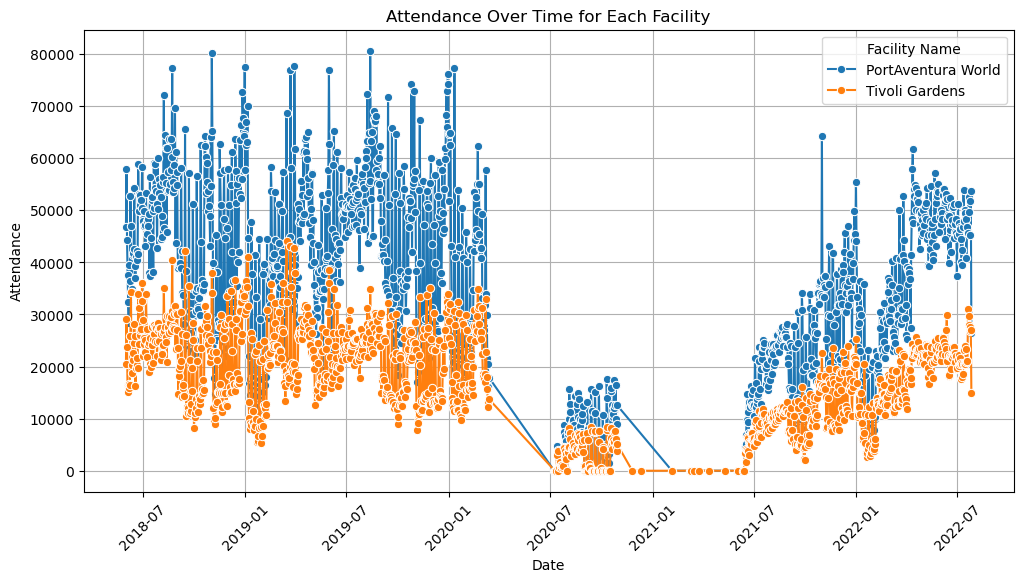

In [114]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Plot attendance over time for each facility
sns.lineplot(data=attendance_data, x="USAGE_DATE", y="attendance", hue="FACILITY_NAME", marker="o")

# Beautify the plot
plt.xlabel("Date")
plt.ylabel("Attendance")
plt.title("Attendance Over Time for Each Facility")
plt.xticks(rotation=45)
plt.legend(title="Facility Name")
plt.grid(True)

# Show the plot
plt.show()

#### Monthly Trend for each year
Attendance from both parks follows the same trend roughly. Before Covid-19, summer break and winter break periods saw an increase in attendance.

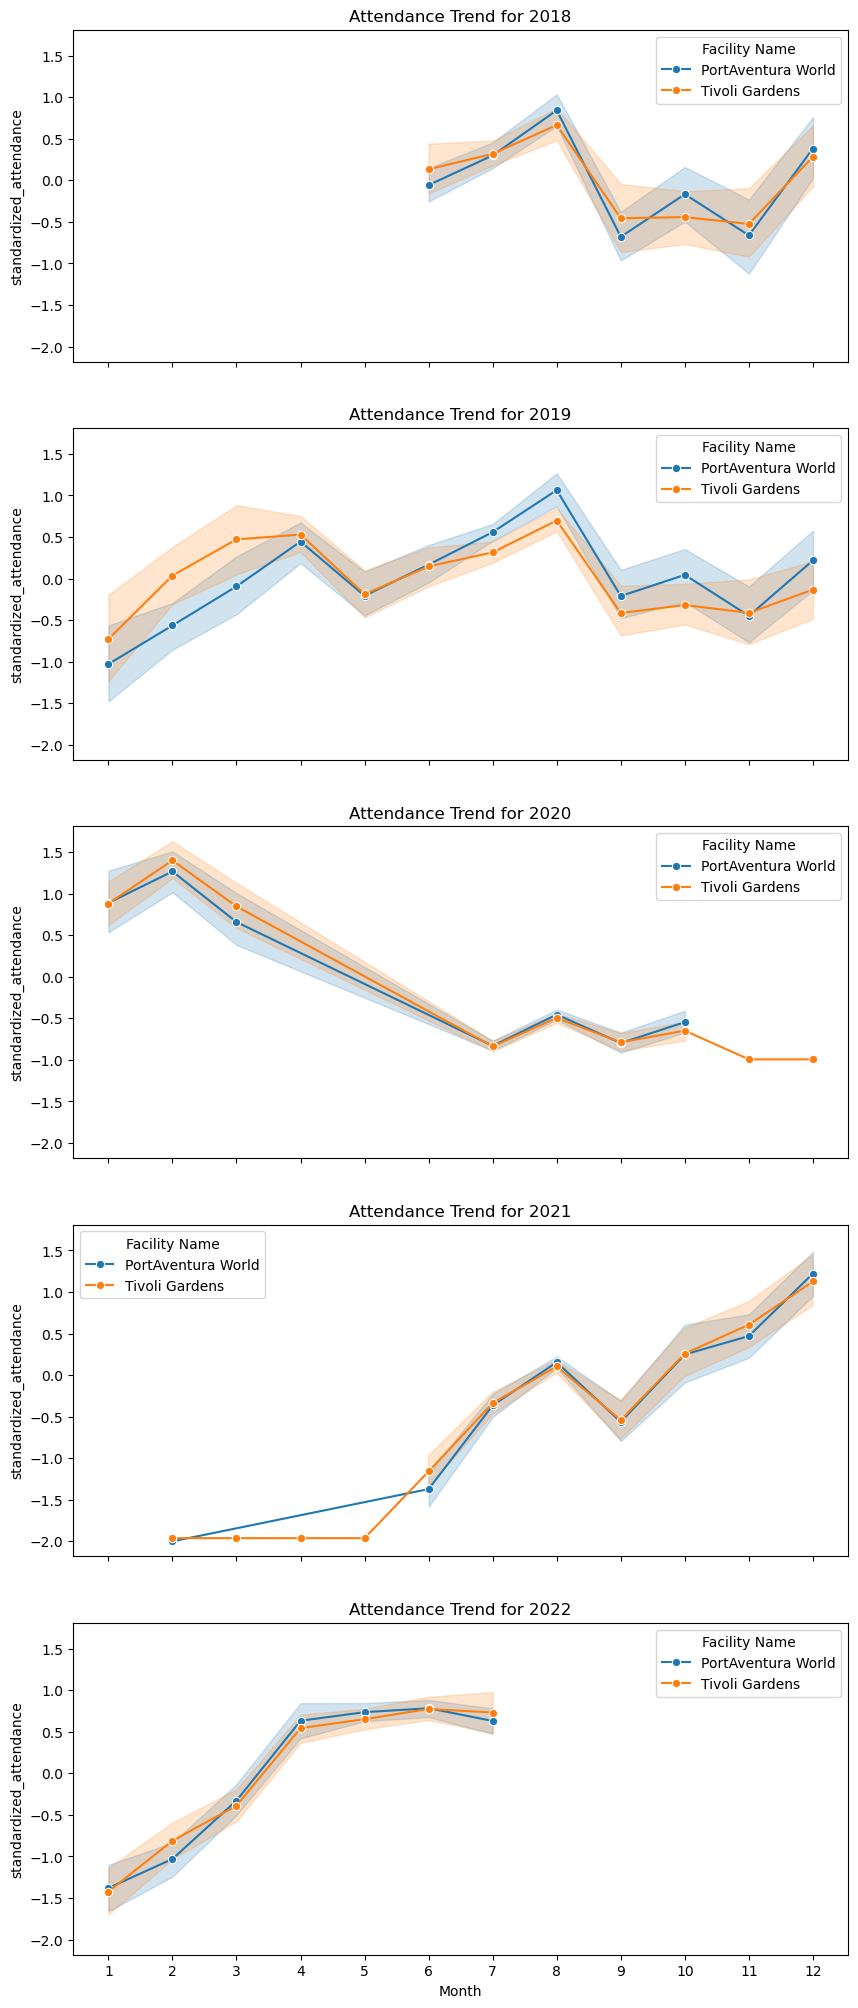

In [115]:
attendance_data["Year"] = attendance_data["USAGE_DATE"].dt.year
attendance_data["Month"] = attendance_data["USAGE_DATE"].dt.month
attendance_data.head()

monthly_facility_mean = attendance_data.groupby(["Year", "Month", "FACILITY_NAME"])["attendance"].mean().reset_index()
unique_years = monthly_facility_mean["Year"].unique()
num_years = len(unique_years)

fig, axes = plt.subplots(num_years, 1, figsize=(10, 5 * num_years), sharex=True, sharey=True)

# Ensure axes is iterable even if there's only one year
if num_years == 1:
    axes = [axes]

# Plot each year separately
for i, year in enumerate(sorted(unique_years)):
    ax = axes[i]
    subset = attendance_data[attendance_data["Year"] == year]  # Filter data for the current year
    
    sns.lineplot(data=subset, x="Month", y="standardized_attendance", hue="FACILITY_NAME", marker="o", ax=ax)
    
    ax.set_title(f"Attendance Trend for {year}")
    ax.set_xticks(range(1, 13))  # Ensure all months 1-12 appear on x-axis
    ax.set_xlabel("Month")
    ax.set_ylabel("standardized_attendance")
    ax.legend(title="Facility Name")
    

plt.show()

#### Daily trend
Days of the week attendance data was investigated using maximum attendance per month of each year and mean attendance of each day. The weekends, especially Saturday saw the highest attendance with both having the most count of maximum attendance days for each month of the year as well as having the highest mean attendance.

  USAGE_DATE     FACILITY_NAME_x  attendance  Year  Month Day_of_Week  \
0 2018-06-23  PortAventura World       58821  2018      6    Saturday   
1 2018-06-30      Tivoli Gardens       36005  2018      6    Saturday   
2 2018-07-07      Tivoli Gardens       33899  2018      7    Saturday   
3 2018-07-28  PortAventura World       60031  2018      7    Saturday   
4 2018-08-23  PortAventura World       77261  2018      8    Thursday   

   mean_attendance  std_attendance  standardized_attendance  \
0     45461.004673    13418.682302                 0.995626   
1     22760.574766     7124.590921                 1.858973   
2     22760.574766     7124.590921                 1.563378   
3     45461.004673    13418.682302                 1.085799   
4     45461.004673    13418.682302                 2.369830   

      FACILITY_NAME_y  
0  PortAventura World  
1      Tivoli Gardens  
2      Tivoli Gardens  
3  PortAventura World  
4  PortAventura World  


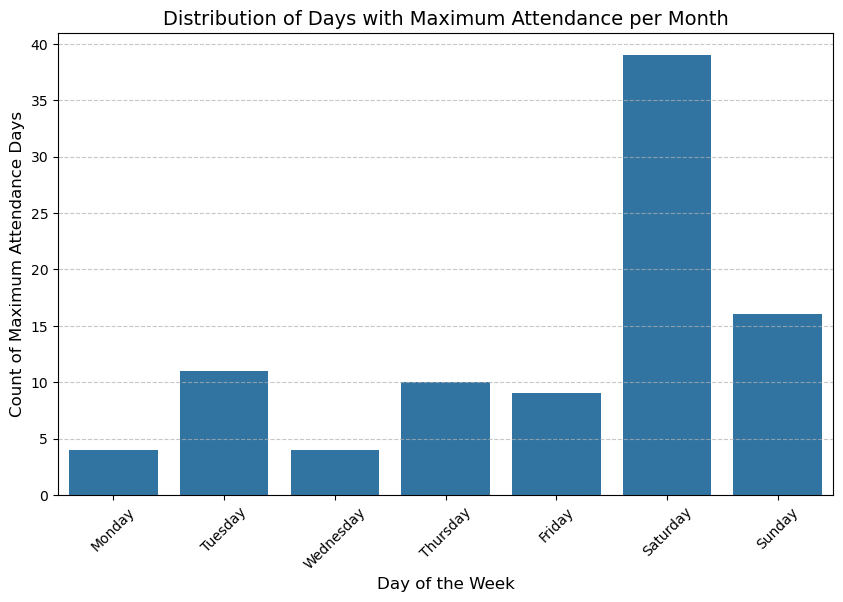

In [117]:
# Group by Year and Month, then find the maximum attendance
max_attendance_per_month = attendance_data.groupby(["Year", "Month", "FACILITY_NAME"])["attendance"].max().reset_index()
max_attendance_dates =  attendance_data.merge(max_attendance_per_month, on=["Year", "Month", "attendance"], how="inner")

# Display the result
print(max_attendance_dates.head())

#plot day distribution
# Count occurrences of each day in the max attendance dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=max_attendance_dates, x="Day_of_Week", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Customize the plot
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Count of Maximum Attendance Days", fontsize=12)
plt.title("Distribution of Days with Maximum Attendance per Month", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()



Barplot

  Day_of_Week  mean_attendance
1      Monday     26259.426115
5     Tuesday     26110.492503
6   Wednesday     26008.401752
4    Thursday     25841.201443
0      Friday     26119.796895
2    Saturday     26317.051074
3      Sunday     26269.785731


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/672626059.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


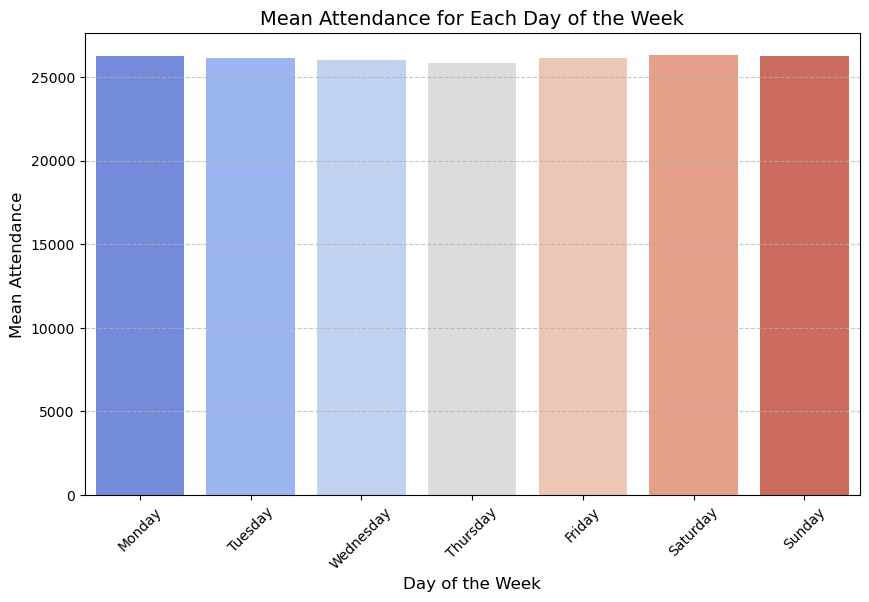

In [118]:
# Group data by Day_of_Week and calculate mean attendance
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert 'Day_of_Week' to a categorical variable with the correct order
mean_attendance_per_day["Day_of_Week"] = pd.Categorical(mean_attendance_per_day["Day_of_Week"], categories=day_order, ordered=True)
mean_attendance_per_day = mean_attendance_per_day.sort_values("Day_of_Week")
print(mean_attendance_per_day)

# Set figure size
plt.figure(figsize=(10, 6))

# Create bar plot
sns.barplot(
    data=mean_attendance_per_day, 
    x="Day_of_Week", 
    y="mean_attendance", 
    order=day_order,
    palette="coolwarm"
)

# Customize the plot
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Mean Attendance", fontsize=12)
plt.title("Mean Attendance for Each Day of the Week", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

Line plot

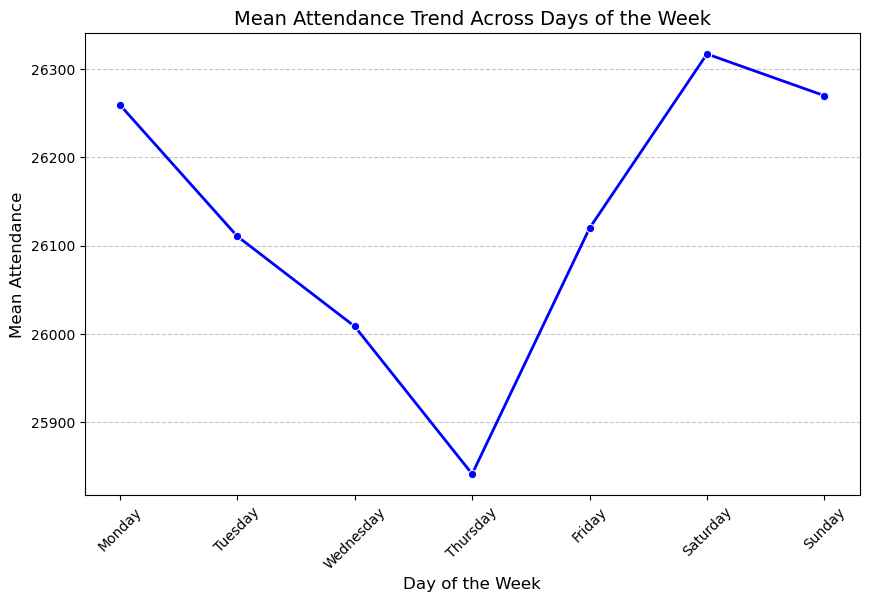

In [119]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create line plot
sns.lineplot(
    data=mean_attendance_per_day, 
    x="Day_of_Week", 
    y="mean_attendance", 
    marker="o",  # Add markers to indicate each point
    linewidth=2, 
    color="blue"
)

# Customize the plot
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Mean Attendance", fontsize=12)
plt.title("Mean Attendance Trend Across Days of the Week", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

#### Local events and holidays
Attendance on holidays are higher than on non-holidays. Holidays such as Christmas and New Years are more popular times where people go to the parks.

In [120]:
#PortAventura World
portaventura_df = attendance_data[attendance_data["FACILITY_NAME"] == "PortAventura World"]

#Tivoli Gardens	
tivoli_df = attendance_data[attendance_data["FACILITY_NAME"] == "Tivoli Gardens"]

##### PortAventura World (Spain)

Average attendance on holidays: 43767.57692307692
Average attendance on non-holidays: 34741.14273356401
T-statistic: 2.799057438576239, P-value: 0.009453542443116381


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/3214050399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portaventura_df["is_holiday"] = portaventura_df["USAGE_DATE"].apply(lambda x: x in spain_holidays)


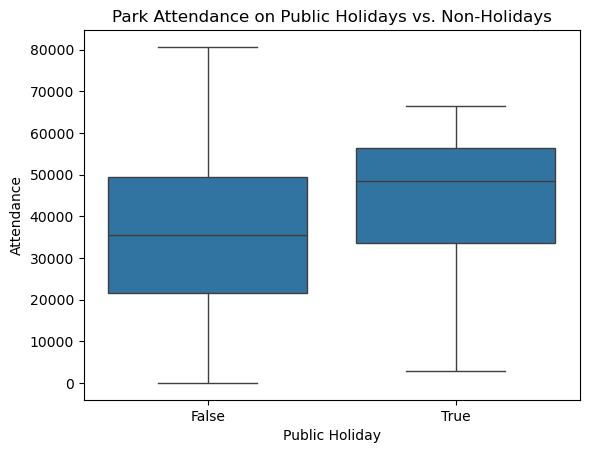

In [121]:
spain_holidays = holidays.Spain(years=[2018, 2019, 2020, 2021, 2022])
portaventura_df["is_holiday"] = portaventura_df["USAGE_DATE"].apply(lambda x: x in spain_holidays)

#Check average attendance on holidays
holiday_attendance = portaventura_df[portaventura_df["is_holiday"] == True]["attendance"].mean()
non_holiday_attendance = portaventura_df[portaventura_df["is_holiday"] == False]["attendance"].mean()

print(f"Average attendance on holidays: {holiday_attendance}")
print(f"Average attendance on non-holidays: {non_holiday_attendance}")

#Use T-test and p value to see if it is statistically significant
holiday_values = portaventura_df[portaventura_df["is_holiday"] == True]["attendance"]
non_holiday_values = portaventura_df[portaventura_df["is_holiday"] == False]["attendance"]

t_stat, p_value = ttest_ind(holiday_values, non_holiday_values, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}") #p-value less than 0.05, statistically significant

#Plot
sns.boxplot(x=portaventura_df["is_holiday"], y=portaventura_df["attendance"])
plt.xlabel("Public Holiday")
plt.ylabel("Attendance")
plt.title("Park Attendance on Public Holidays vs. Non-Holidays")
plt.show()


     holiday_name    attendance
0   Christmas Day  56117.666667
1        Epiphany  34882.000000
2       Labor Day  51284.000000
3  New Year's Day  51201.333333
4     Non-Holiday  34816.009394


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/1233065620.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portaventura_df["holiday_name"] = portaventura_df["USAGE_DATE"].apply(get_holiday)
/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/1233065620.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")


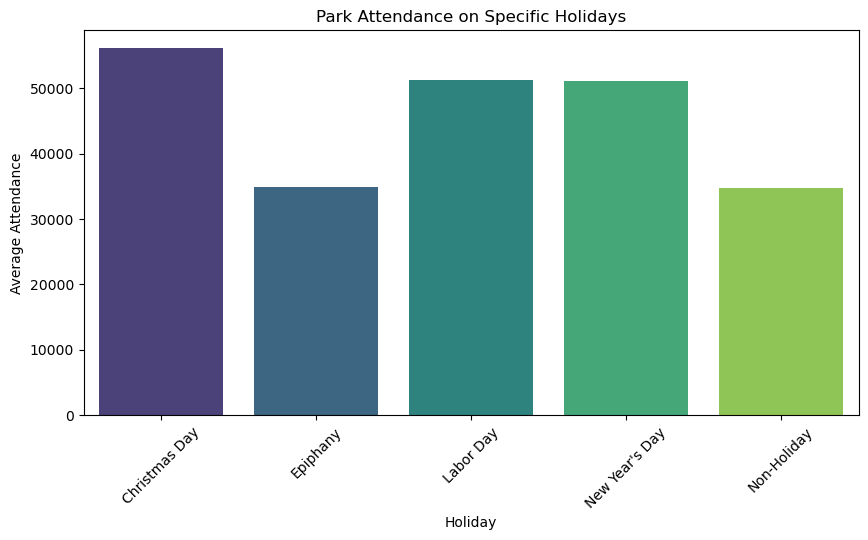

In [122]:
#Check to see if some holidays affected more

spain_holidays = holidays.Spain(years=portaventura_df["Year"].unique())

# Select specific major holidays
key_holidays = {
    "New Year's Day": "01-01",
    "Epiphany": "01-06",
    "Easter Sunday": "variable",
    "Labor Day": "05-01",
    "Christmas Day": "12-25"
}

# Convert variable holidays like Easter Sunday
key_holidays["Easter Sunday"] = [date for date in spain_holidays if "Easter Sunday" in spain_holidays.get(date)]

def get_holiday(date):
    date_str = date.strftime("%m-%d")
    for holiday, value in key_holidays.items():
        if isinstance(value, list) and date in value:
            return holiday
        elif date_str == value:
            return holiday
    return "Non-Holiday"

portaventura_df["holiday_name"] = portaventura_df["USAGE_DATE"].apply(get_holiday)

holiday_attendance = portaventura_df.groupby("holiday_name")["attendance"].mean().reset_index()
print(holiday_attendance)

#Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")

plt.xlabel("Holiday")
plt.ylabel("Average Attendance")
plt.title("Park Attendance on Specific Holidays")
plt.xticks(rotation=45)
plt.show()

##### Tivoli Garden (Denmark)

/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/1245891564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tivoli_df["is_holiday"] = tivoli_df["USAGE_DATE"].apply(lambda x: x in denmark_holidays)


Average attendance on holidays: 25439.96
Average attendance on non-holidays: 17170.93017241379
T-statistic: 8.228205089324502, P-value: 6.415605888443691e-09


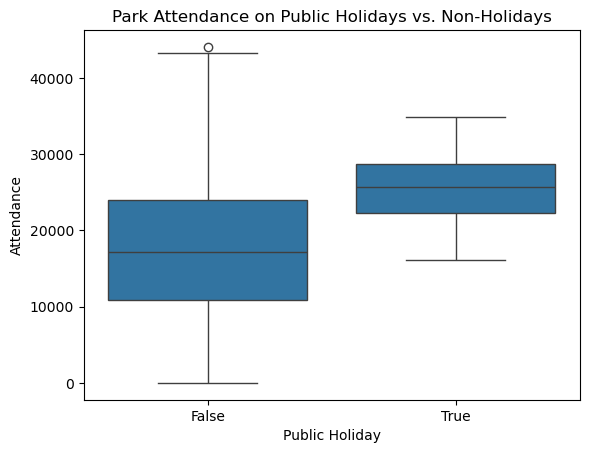

In [123]:
denmark_holidays = holidays.Denmark(years=[2018, 2019, 2020, 2021, 2022])
tivoli_df["is_holiday"] = tivoli_df["USAGE_DATE"].apply(lambda x: x in denmark_holidays)

#Check average attendance on holidays
holiday_attendance = tivoli_df[tivoli_df["is_holiday"] == True]["attendance"].mean()
non_holiday_attendance = tivoli_df[tivoli_df["is_holiday"] == False]["attendance"].mean()

print(f"Average attendance on holidays: {holiday_attendance}")
print(f"Average attendance on non-holidays: {non_holiday_attendance}")

#Use T-test and p value to see if it is statistically significant
holiday_values = tivoli_df[tivoli_df["is_holiday"] == True]["attendance"]
non_holiday_values = tivoli_df[tivoli_df["is_holiday"] == False]["attendance"]

t_stat, p_value = ttest_ind(holiday_values, non_holiday_values, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}") #p-value less than 0.05, statistically significant

#Plot
sns.boxplot(x=tivoli_df["is_holiday"], y=tivoli_df["attendance"])
plt.xlabel("Public Holiday")
plt.ylabel("Attendance")
plt.title("Park Attendance on Public Holidays vs. Non-Holidays")
plt.show()


       holiday_name    attendance
0        Boxing Day  23494.666667
1     Christmas Day  25168.000000
2     Christmas Eve  18326.333333
3  Constitution Day  19674.333333
4    New Year's Day  25386.333333
5       Non-Holiday  17280.452137


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/3146966411.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tivoli_df["holiday_name"] = tivoli_df["USAGE_DATE"].apply(get_holiday)
/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_13191/3146966411.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")


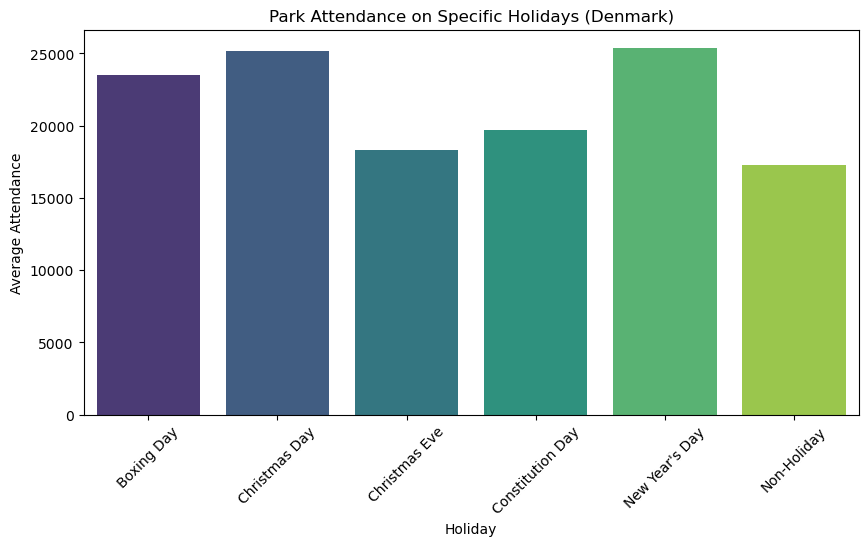

In [129]:
#Check to see if some holidays affected more

denmark_holidays = holidays.Denmark(years=tivoli_df["Year"].unique())

# Select specific major holidays
key_holidays = {
    "New Year's Day": "01-01",
    "Easter Sunday": "variable",
    "Great Prayer Day": "variable",
    "Ascension Day": "variable",
    "Constitution Day": "06-05",
    "Christmas Eve": "12-24",
    "Christmas Day": "12-25",
    "Boxing Day": "12-26"
}

# Convert variable holidays (e.g., Easter Sunday, Great Prayer Day)
variable_holidays = {}

for date, name in denmark_holidays.items():
    holiday_name = str(name)  # Convert holiday name to a string
    if any(h in holiday_name for h in ["Easter", "Great Prayer", "Ascension"]):
        variable_holidays[holiday_name] = date

# Add variable holidays to key_holidays
key_holidays.update(variable_holidays)

def get_holiday(date):
    date_str = date.strftime("%m-%d")
    for holiday, value in key_holidays.items():
        if isinstance(value, list) and date in value:
            return holiday
        elif date_str == value:
            return holiday
    return "Non-Holiday"

tivoli_df["holiday_name"] = tivoli_df["USAGE_DATE"].apply(get_holiday)

holiday_attendance = tivoli_df.groupby("holiday_name")["attendance"].mean().reset_index()
print(holiday_attendance)

plt.figure(figsize=(10, 5))
sns.barplot(data=holiday_attendance, x="holiday_name", y="attendance", palette="viridis")

plt.xlabel("Holiday")
plt.ylabel("Average Attendance")
plt.title("Park Attendance on Specific Holidays (Denmark)")
plt.xticks(rotation=45)
plt.show()


### DisneyLand Reviews data

#### Sentiment and Ratings Analysis

Get a sentiment score

In [124]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
DisneylandReviews_data["Sentiment_Score"] = DisneylandReviews_data["Review_Text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Display results
DisneylandReviews_data.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/clarakan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,Sentiment_Score
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019.0,4.0,0.7069
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019.0,5.0,0.9901
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019.0,4.0,0.9920
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019.0,4.0,0.8489
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019.0,4.0,0.2846


#### Check which months on average have better sentiment scores and ratings

    Month  Sentiment_Score
0     1.0         0.691943
1     2.0         0.672202
2     3.0         0.688678
3     4.0         0.678027
4     5.0         0.678922
5     6.0         0.675676
6     7.0         0.692016
7     8.0         0.652312
8     9.0         0.697164
9    10.0         0.682387
10   11.0         0.706328
11   12.0         0.675380


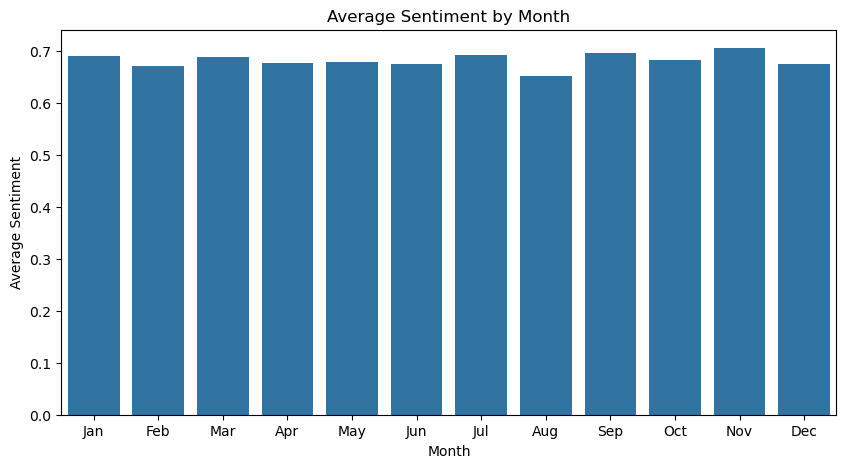

In [126]:
monthly_sentiment = DisneylandReviews_data.groupby("Month")["Sentiment_Score"].mean().reset_index()
print(monthly_sentiment)

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_sentiment["Month"], y=monthly_sentiment["Sentiment_Score"])

plt.xlabel("Month")
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment by Month")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

    Month    Rating
0     1.0  4.292528
1     2.0  4.204961
2     3.0  4.215380
3     4.0  4.201553
4     5.0  4.232335
5     6.0  4.194150
6     7.0  4.213402
7     8.0  4.115423
8     9.0  4.362229
9    10.0  4.239373
10   11.0  4.324395
11   12.0  4.235157


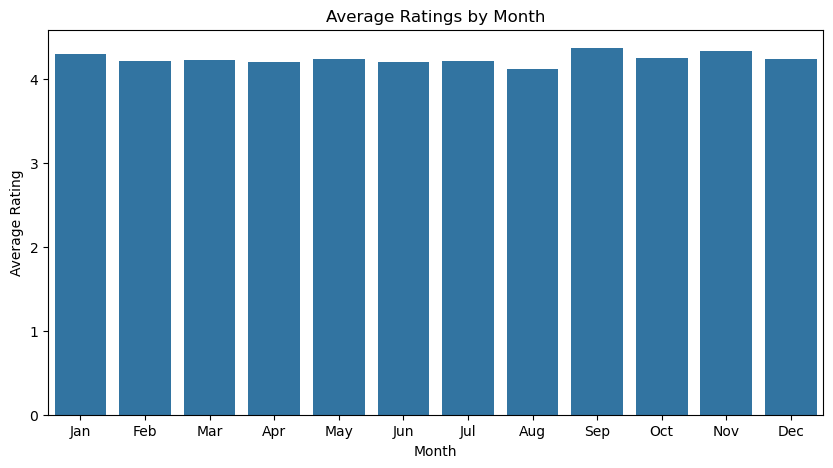

In [127]:
monthly_ratings = DisneylandReviews_data.groupby("Month")["Rating"].mean().reset_index()
print(monthly_ratings)

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_ratings["Month"], y=monthly_ratings["Rating"])

plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.title("Average Ratings by Month")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


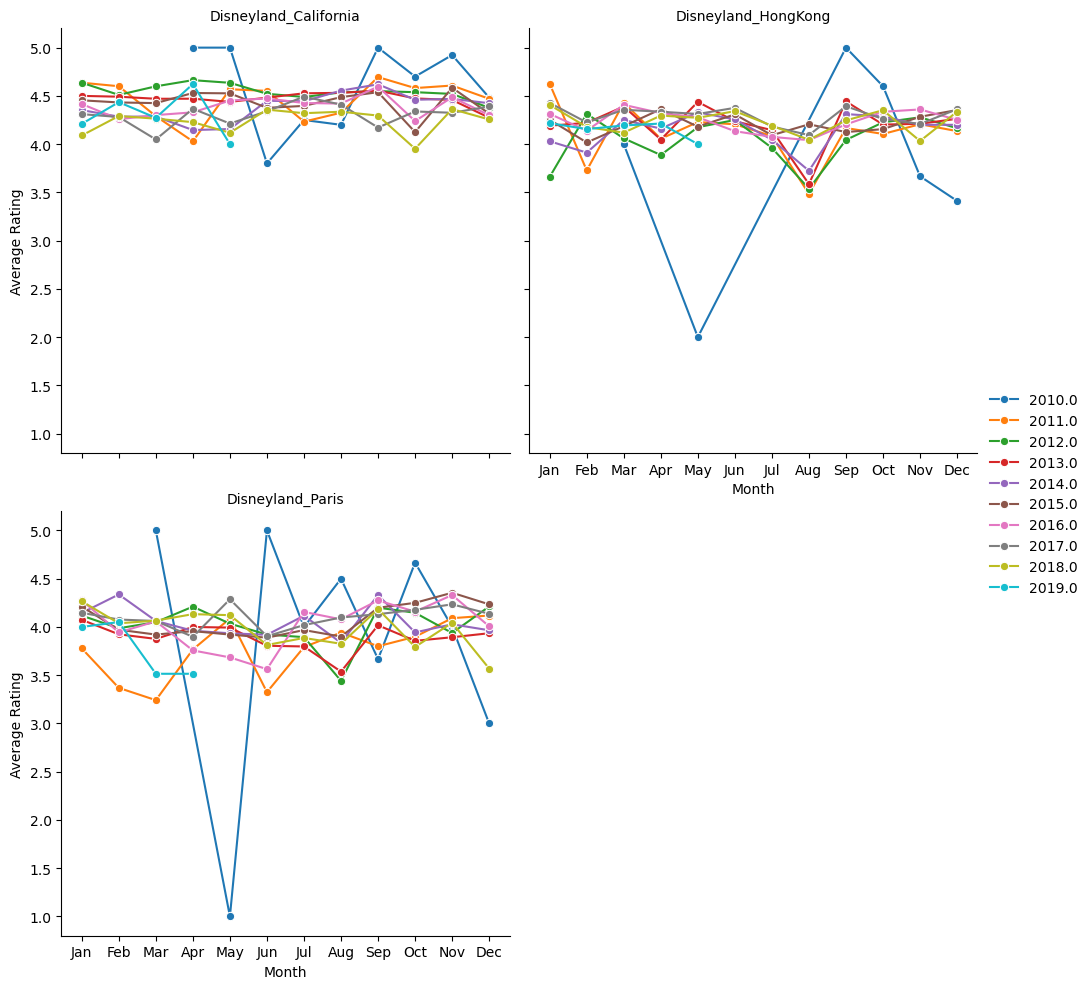

In [128]:
#Check year and month
ratings_trend = DisneylandReviews_data.groupby(["Branch", "Year", "Month"])["Rating"].mean().reset_index()

g = sns.FacetGrid(ratings_trend, col="Branch", col_wrap=2, height=5, sharey=True)
g.map_dataframe(sns.lineplot, x="Month", y="Rating", hue="Year", marker="o", palette="tab10")

g.set_axis_labels("Month", "Average Rating")
g.set_titles("{col_name}")  # Set branch name as title
g.add_legend()

plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


Use a heatmap to check rating and sentiment differences for each branch, California and Hong Kong in general have higher ratings and sentiments.

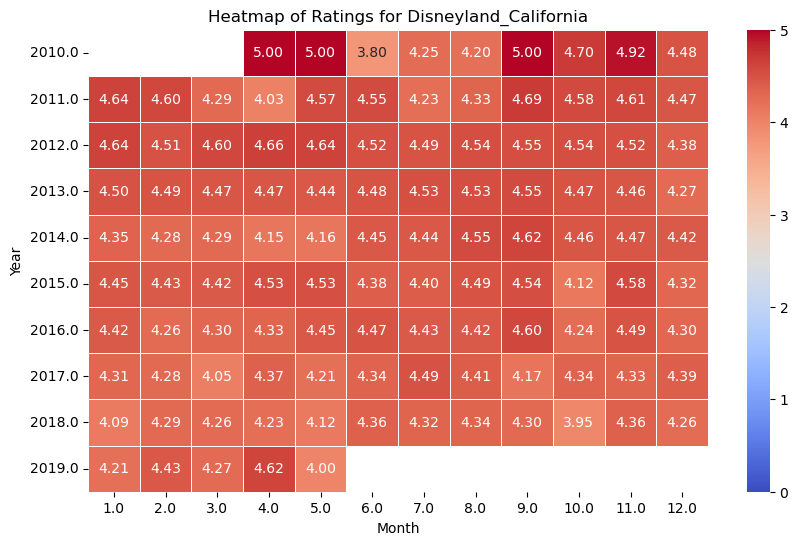

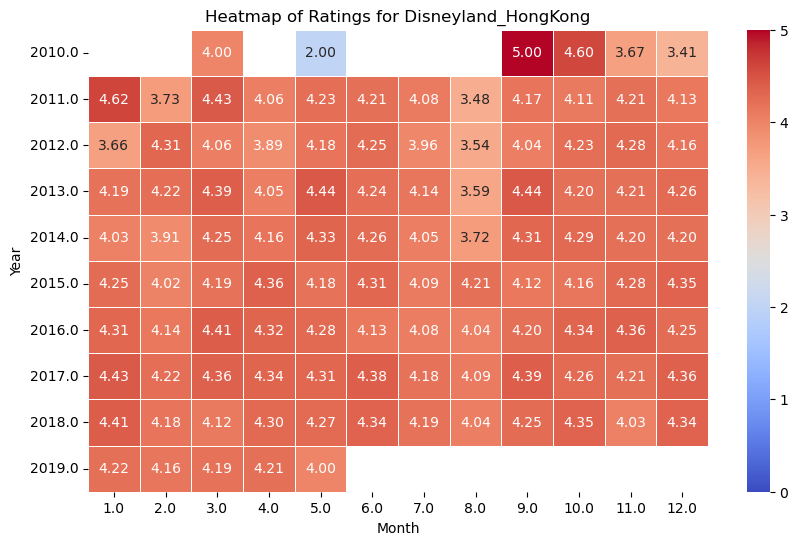

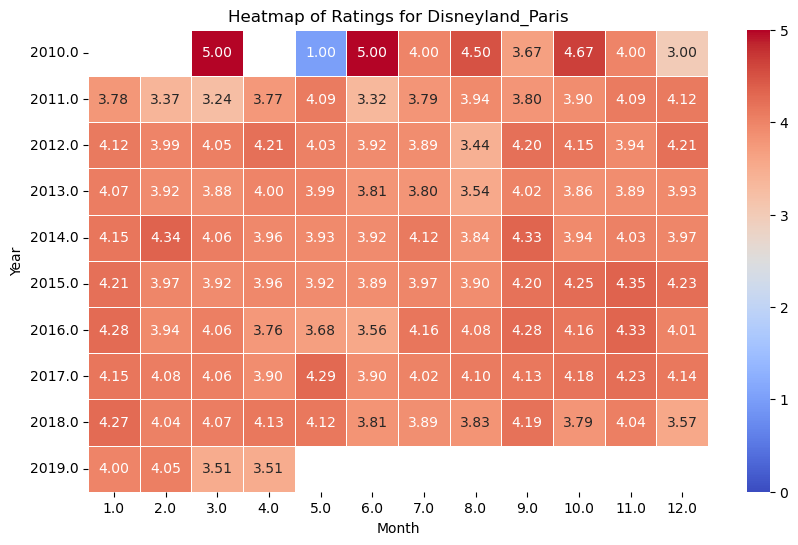

In [129]:
branches = ratings_trend["Branch"].unique()

for branch in branches:
    plt.figure(figsize=(10, 6))
    branch_data = ratings_trend[ratings_trend["Branch"] == branch].pivot(index="Year", columns="Month", values="Rating")

    # Define a consistent color range from 0 to 5
    sns.heatmap(branch_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, vmin=0, vmax=5)
    
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.title(f"Heatmap of Ratings for {branch}")
    plt.show()


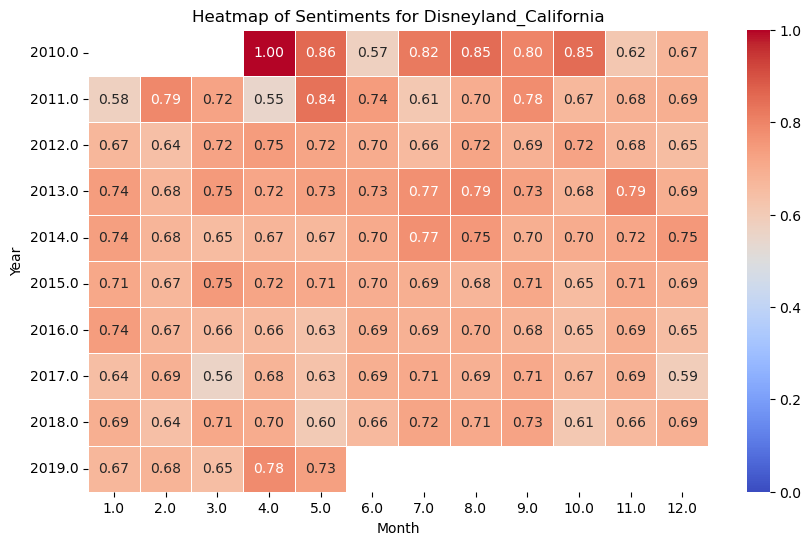

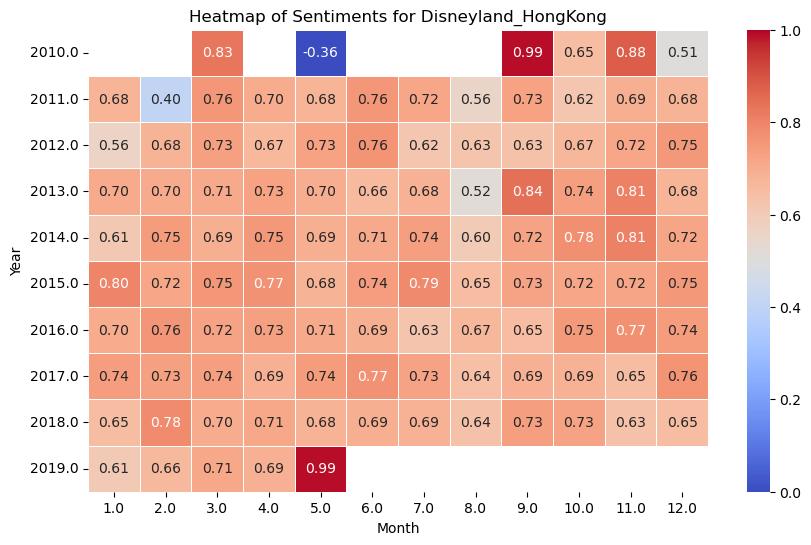

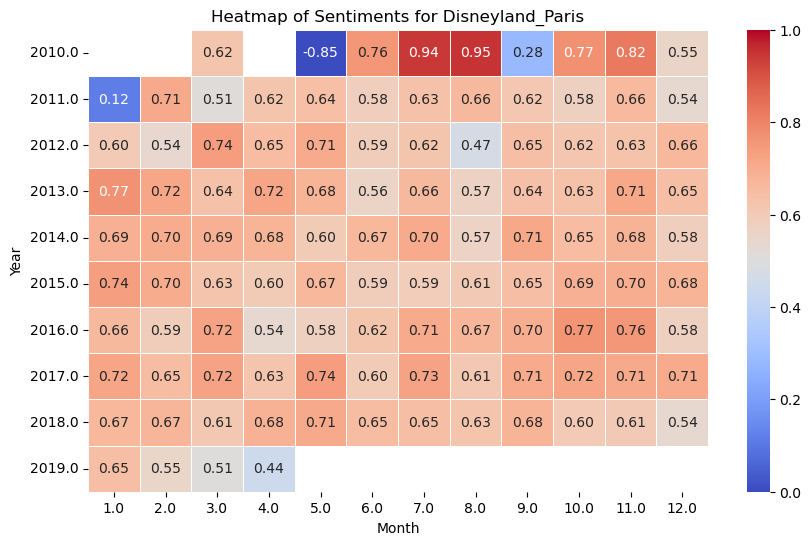

In [130]:
sentiment_trend = DisneylandReviews_data.groupby(["Branch", "Year", "Month"])["Sentiment_Score"].mean().reset_index()
branches = sentiment_trend["Branch"].unique()

for branch in branches:
    plt.figure(figsize=(10, 6))
    branch_data = sentiment_trend[sentiment_trend["Branch"] == branch].pivot(index="Year", columns="Month", values="Sentiment_Score")

    # Define a consistent color range from 0 to 5
    sns.heatmap(branch_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, vmin=0, vmax=1)
    
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.title(f"Heatmap of Sentiments for {branch}")
    plt.show()

#### Visit Type
Check to see who reviewers visited the park with and categorise into family, couples, friends and solo

In [131]:
# Categorizing visit type
DisneylandReviews_data['Visit_Type'] = DisneylandReviews_data['Review_Text'].apply(lambda x: 
    'Family' if any(word in x.lower() for word in ['family', 'my kids', 'the kids', 'my children', 'parents', 'wife', 'husband', 'baby', 
                       'toddler', 'son', 'daughter', 'mom', 'dad', 'grandma', 'grandpa', 'grandmother', 'grandfather', 'grandchild', 'grandchildren', 'grandson', 'grandaughter', 
                       'cousins', 'nephew', 'niece', 'the kids', 'little ones', 'family-friendly']) else
    'Couples' if any(word in x.lower() for word in ['boyfriend', 'girlfriend', 'my partner', 'honeymoon', 'fiance', 'fiancee', 'anniversary trip', 'couples retreat' ]) else                                                                                 
    'Friends' if any(word in x.lower() for word in ['friends', 'buddies', 'hangout', 'bestie', 'friend']) else                                                                
    'Solo' if any(word in x.lower() for word in ['solo trip', 'by myself']) else 'Unknown'
)
DisneylandReviews_data.head()


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,Sentiment_Score,Visit_Type
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019.0,4.0,0.7069,Unknown
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019.0,5.0,0.9901,Unknown
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019.0,4.0,0.9920,Unknown
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019.0,4.0,0.8489,Unknown
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019.0,4.0,0.2846,Family


Check to see which continent the reviewers are from

In [132]:
# Categorizing Reviewer_Location

def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Unknown"  # Handle errors (e.g., missing or incorrect country names)


# Apply function to the 'Reviewer_Location' column
DisneylandReviews_data["Continent"] = DisneylandReviews_data["Reviewer_Location"].apply(country_to_continent)
DisneylandReviews_data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,Sentiment_Score,Visit_Type,Continent
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019.0,4.0,0.7069,Unknown,Oceania
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019.0,5.0,0.9901,Unknown,Asia
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019.0,4.0,0.9920,Unknown,Asia
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019.0,4.0,0.8489,Unknown,Oceania
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019.0,4.0,0.2846,Family,Europe


##### Continent and Month of Visit 
People from North America and Europe tend to leave the most reviews consistently.

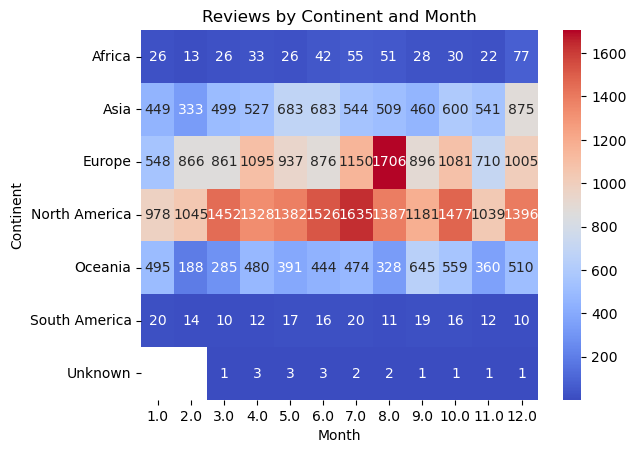

In [133]:
grouped = DisneylandReviews_data.groupby(["Continent", "Month"]).size().reset_index(name="Review_Count")

# Pivot the data for heatmap
pivot = grouped.pivot(index="Continent", columns="Month", values="Review_Count")

# Create the heatmap
sns.heatmap(pivot, cmap="coolwarm", annot=True, fmt="g")  # fmt="g" ensures proper integer formatting

plt.title("Reviews by Continent and Month")
plt.show()


##### Visit Type and Month of Visit
Based on the reviews, most people travel with their family with June to August, October and December being the popular months. This is in line with school holidays such a Summer and Winter break. Guest going with their families tend to give the most reviews

Month         1.0     2.0     3.0     4.0     5.0     6.0     7.0     8.0   \
Visit_Type                                                                   
Couples       17.0    21.0    21.0    34.0    32.0    33.0    26.0    29.0   
Family      1088.0  1089.0  1420.0  1529.0  1481.0  1532.0  1688.0  1798.0   
Friends      118.0   126.0   136.0   175.0   177.0   165.0   150.0   177.0   
Solo           NaN     3.0     1.0     1.0     2.0     2.0     2.0     2.0   
Unknown     1293.0  1220.0  1556.0  1739.0  1747.0  1858.0  2014.0  1988.0   

Month         9.0     10.0    11.0    12.0  
Visit_Type                                  
Couples       42.0    31.0    32.0    29.0  
Family      1345.0  1599.0  1105.0  1744.0  
Friends      157.0   189.0   137.0   176.0  
Solo           1.0     3.0     4.0     1.0  
Unknown     1685.0  1942.0  1407.0  1924.0  


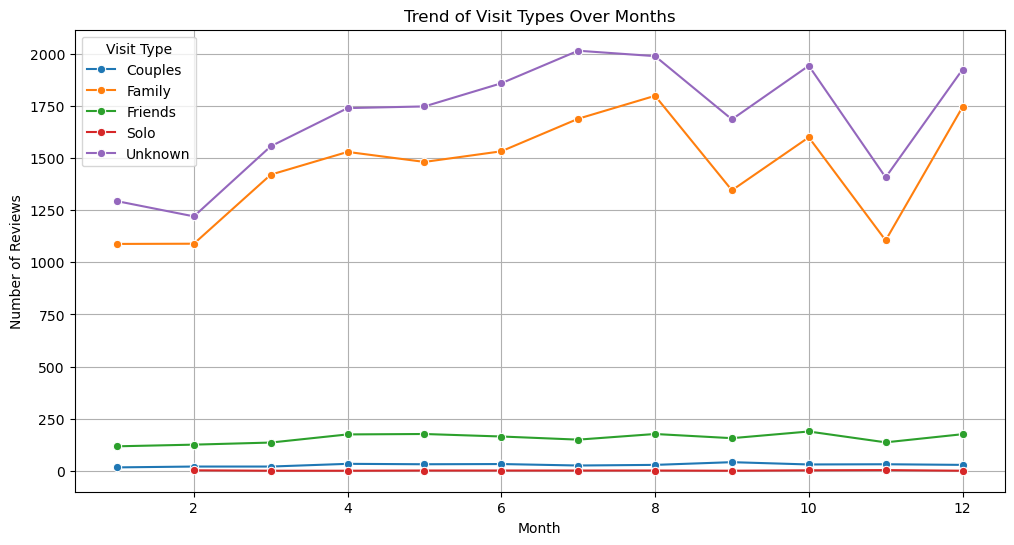

In [134]:
grouped = DisneylandReviews_data.groupby(["Visit_Type", "Month"]).size().reset_index(name="Review_Count")

# Create a pivot table
pivot = grouped.pivot(index="Visit_Type", columns="Month", values="Review_Count")

# Display the pivot table
print(pivot)

# Line plot for trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x="Month", y="Review_Count", hue="Visit_Type", marker="o")

# Labels and title
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Trend of Visit Types Over Months")
plt.legend(title="Visit Type")
plt.grid(True)
plt.show()

##### Visit Type and Ratings/Sentiment Scores

Families tend to give poor ratings

  Visit_Type    Rating
0    Couples  4.365039
1     Family  4.158576
2    Friends  4.310518
3       Solo  4.545455
4    Unknown  4.257824


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/1536345827.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=visit_type_rating, x="Visit_Type", y="Rating", palette="coolwarm")


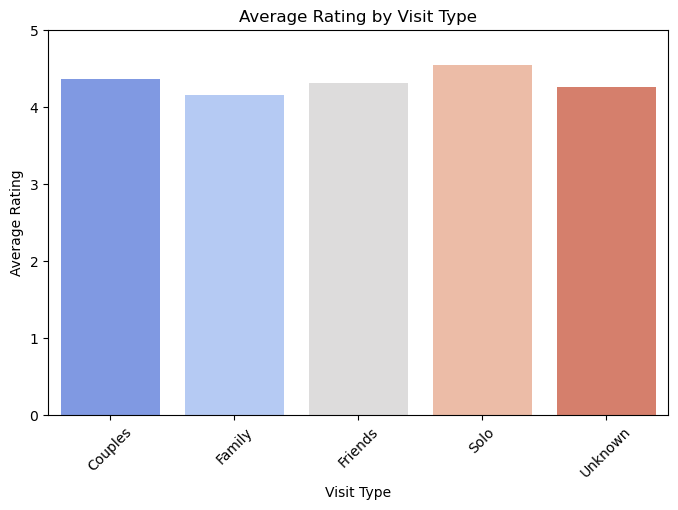

In [135]:
# Group by Visit Type and calculate average rating
visit_type_rating = DisneylandReviews_data.groupby("Visit_Type")["Rating"].mean().reset_index()
print(visit_type_rating)

# Bar plot to visualize ratings by visit type
plt.figure(figsize=(8, 5))
sns.barplot(data=visit_type_rating, x="Visit_Type", y="Rating", palette="coolwarm")

# Labels
plt.xlabel("Visit Type")
plt.ylabel("Average Rating")
plt.title("Average Rating by Visit Type")
plt.xticks(rotation=45)
plt.ylim(0, 5)  # Ratings are between 1-5
plt.show()


  Visit_Type  Sentiment_Score
0    Couples         0.783113
1     Family         0.720112
2    Friends         0.801626
3       Solo         0.670541
4    Unknown         0.636394


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/2533390333.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=visit_type_rating, x="Visit_Type", y="Sentiment_Score", palette="coolwarm")


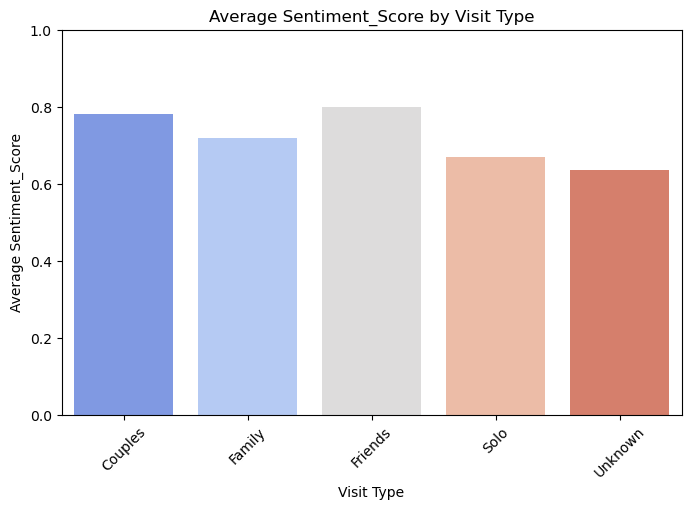

In [136]:
# Group by Visit Type and calculate average rating
visit_type_rating = DisneylandReviews_data.groupby("Visit_Type")["Sentiment_Score"].mean().reset_index()
print(visit_type_rating)

# Bar plot to visualize ratings by visit type
plt.figure(figsize=(8, 5))
sns.barplot(data=visit_type_rating, x="Visit_Type", y="Sentiment_Score", palette="coolwarm")

# Labels
plt.xlabel("Visit Type")
plt.ylabel("Average Sentiment_Score")
plt.title("Average Sentiment_Score by Visit Type")
plt.xticks(rotation=45)
plt.ylim(0, 1)  
plt.show()


##### Continent of origin and rating/sentiment score

People from North America and Oceania tend to give higher ratings. Europeans give the lowest ratings

       Continent    Rating
0         Africa  4.266816
1           Asia  4.224904
2         Europe  4.035535
3  North America  4.315532
4        Oceania  4.321455
5  South America  4.098901
6        Unknown  4.555556


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/1399659873.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=visit_type_rating, x="Continent", y="Rating", palette="coolwarm")


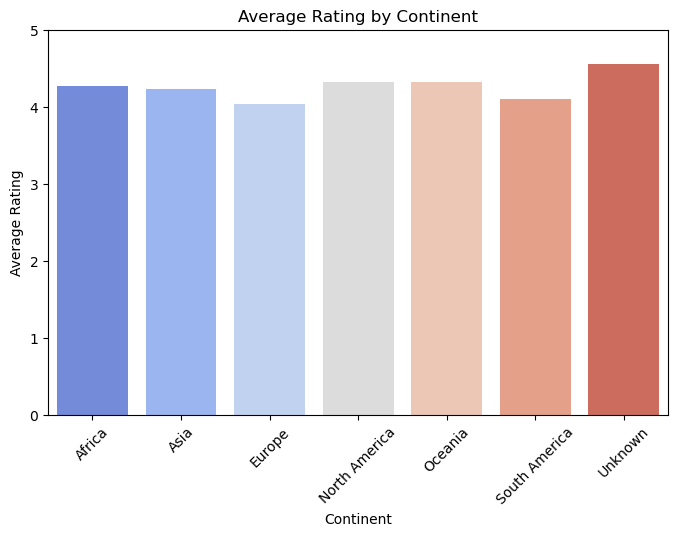

In [137]:
# Group by Visit Type and calculate average rating
visit_type_rating = DisneylandReviews_data.groupby("Continent")["Rating"].mean().reset_index()
print(visit_type_rating)

# Bar plot to visualize ratings by visit type
plt.figure(figsize=(8, 5))
sns.barplot(data=visit_type_rating, x="Continent", y="Rating", palette="coolwarm")

# Labels
plt.xlabel("Continent")
plt.ylabel("Average Rating")
plt.title("Average Rating by Continent")
plt.xticks(rotation=45)
plt.ylim(0, 5)  # Ratings are between 1-5
plt.show()


       Continent  Sentiment_Score
0         Africa         0.648524
1           Asia         0.693790
2         Europe         0.654690
3  North America         0.682622
4        Oceania         0.732898
5  South America         0.676064
6        Unknown         0.716344


/var/folders/xy/mxl2xzz57lgg3w741xs6sb800000gn/T/ipykernel_37150/3232318570.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=visit_type_rating, x="Continent", y="Sentiment_Score", palette="coolwarm")


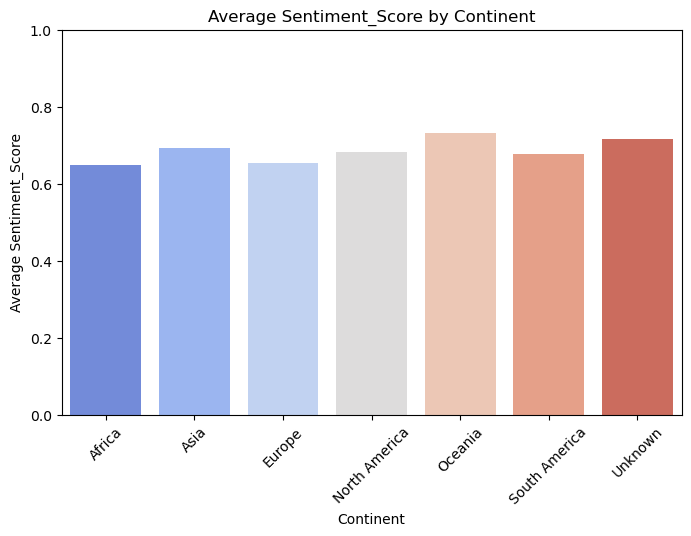

In [138]:
# Group by Visit Type and calculate average rating
visit_type_rating = DisneylandReviews_data.groupby("Continent")["Sentiment_Score"].mean().reset_index()
print(visit_type_rating)

# Bar plot to visualize ratings by visit type
plt.figure(figsize=(8, 5))
sns.barplot(data=visit_type_rating, x="Continent", y="Sentiment_Score", palette="coolwarm")

# Labels
plt.xlabel("Continent")
plt.ylabel("Average Sentiment_Score")
plt.title("Average Sentiment_Score by Continent")
plt.xticks(rotation=45)
plt.ylim(0, 1)  
plt.show()


### Ratings vs Attendance
Does higher ratings mean more attendance? The correlation value of 0.525 suggests that there is a moderate positive relationship between previous year ratings and next year's attendance.

In [139]:
avg_rating_per_park_year = DisneylandReviews_data.groupby(["Branch", "Year"])["Rating"].mean().reset_index()

# Merge attendance_disney and avg_rating_per_park_year on "Park" and "Year"
merged_df = pd.merge(attendance_disney, avg_rating_per_park_year, left_on=["Park", "Year"], right_on=["Branch", "Year"], how="outer")

# Drop duplicate column
merged_df.drop(columns=["Branch"], inplace=True)

#Shift ratings by 1 year
merged_df["Prev_Year_Rating"] = merged_df.groupby("Park")["Rating"].shift(1)

# Drop rows where previous year's rating is NaN (first year has no previous year)
merged_df = merged_df.dropna()
merged_df.head()

correlation = merged_df["Prev_Year_Rating"].corr(merged_df["Attendance"])
print(correlation)

0.5251558854655396


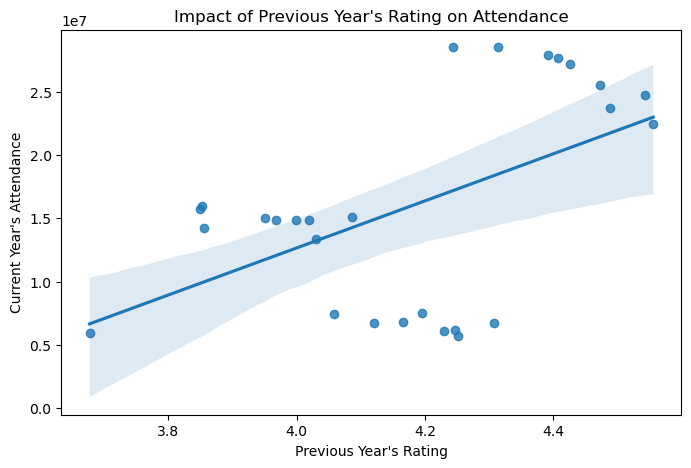

In [140]:
plt.figure(figsize=(8, 5))
sns.regplot(x=merged_df["Prev_Year_Rating"], y=merged_df["Attendance"])
plt.xlabel("Previous Year's Rating")
plt.ylabel("Current Year's Attendance")
plt.title("Impact of Previous Year's Rating on Attendance")
plt.show()